## Environment setup


In [154]:
import sys
from pathlib import Path
import shutil
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from ipywidgets import IntProgress


if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -a "/content/drive/MyDrive/Colab Notebooks/cv-assignment-2/UCMerced_LandUse" .
    !cp -a "/content/drive/MyDrive/Colab Notebooks/cv-assignment-2/helpers.py" .
    path = Path("/content")
elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    path = Path("/kaggle/input/ucmerced-landuse")
else:
    path = Path("D:/MS/cv-assignment-2")
    helpers_file = "G:/My Drive/Colab Notebooks/cv-assignment-2/helpers.py"
    destination_file = path / "helpers.py"
    shutil.copy(helpers_file, destination_file)
from helpers import *

print(f"using Data in directory: {str(path)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using Data in directory: /content


In [155]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"using Device: {device}")

using Device: cpu


## Transforms


In [ ]:
from torchvision.transforms import v2
from torchvision.transforms.functional import rotate
import random


class RandomRotationFromList:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return rotate(img, angle)


image_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((256, 256)),
        RandomRotationFromList([90, 180, 270]),
        v2.RandomVerticalFlip(),
    ]
)
categories = os.listdir(path / "UCMerced_LandUse/Images")
label_transform = v2.Lambda(
    lambda label: torch.zeros(21, dtype=torch.float).scatter(
        0, torch.tensor(categories.index(label)), 1
    )
)

## Datasets and loaders


In [ ]:
class terrainDataset(Dataset):
    def __init__(self, path: Path, transform=None, target_transform=None, test=False):
        self.data = []
        self.categories = os.listdir(path)
        for category in self.categories:
            images = [path / category / image for image in os.listdir(path / category)]
            if test:
                images = images[90:]
            else:
                images = images[:90]
            self.data.extend(list(zip(images, [category] * len(images))))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(str(self.data[idx][0]))
        label = self.data[idx][1]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return (img, label)

In [ ]:
train_ds = terrainDataset(
    path / "UCMerced_LandUse/Images",
    transform=image_transforms,
    target_transform=label_transform,
)
test_ds = terrainDataset(
    path / "UCMerced_LandUse/Images",
    transform=image_transforms,
    target_transform=label_transform,
    test=True,
)
batch_size = 64
train_dl = DataLoader(train_ds, 64, shuffle=True)
test_dl = DataLoader(test_ds, 32)

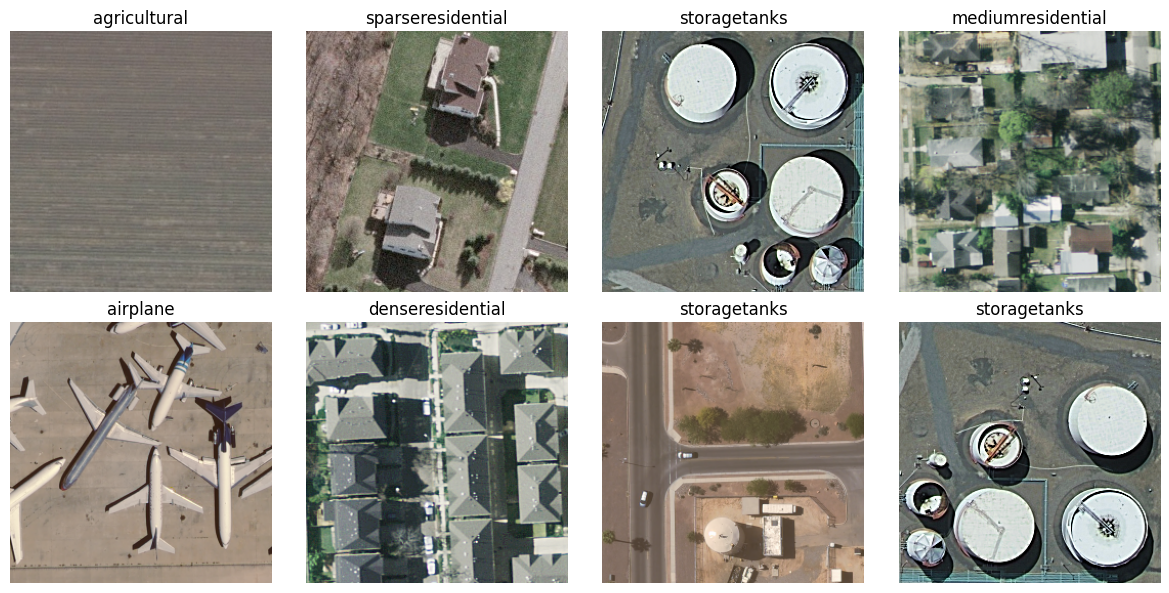

In [ ]:
showbatch(train_ds)

In [ ]:
print(f"train dataset size: {len(train_ds)} | Batches: {len(train_dl)} ")
print(
    f"test dataset size: {len(test_ds)} | Batches: {len(test_dl)}\ntotal: {len(train_ds)+len(test_ds)}"
)

train dataset size: 1890 | Batches: 30 
test dataset size: 210 | Batches: 7
total: 2100


In [ ]:
from torch import nn

loss_func = nn.CrossEntropyLoss()
learning_rate = 0.002

## Train Test loops


In [ ]:
progress = IntProgress(min=0, max=100)
display(progress)


def extraction_loop(dataloader, model, loss_fn, optimizer, dataset, scheduler):
    model.train()
    train_loss = 0
    print(f'lr: {optimizer.param_groups[0]["lr"]}')
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (batch + 1) % 5 == 0:
            loss, current = loss.item(), batch * batch_size + len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataset):>5d}]")
    train_loss /= len(dataloader)
    scheduler.step()
    return train_loss

IntProgress(value=0)

In [ ]:
def test_loop(dataloader, model, loss_fn, dataset):
    model.eval()
    correct, test_loss = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            test_loss += loss_fn(out, y).item()
            correct += (out.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= len(dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

# Transfer Learning


In [ ]:
from torchvision.models import resnet50

resnet = resnet50(weights="IMAGENET1K_V1")
for parameters in resnet.parameters():
    parameters.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 21)
resnet = resnet.to(device)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler


optimizer = torch.optim.SGD(resnet.parameters(), lr=0.002)
scheduler = lr_scheduler.LinearLR(
    optimizer, start_factor=1.0, end_factor=0.01, total_iters=6
)

In [ ]:
epochs = 1
for e in range(epochs):
    print(f"_______________\nepoch: {e+1}:")
    train_losses = []
    train_loss = extraction_loop(train_dl, resnet, loss_func, optimizer, train_ds, scheduler)
    train_losses.append(train_loss)
    test_loop(test_dl, resnet, loss_func, test_ds)
epochs = 14
for parameters in resnet.parameters():
    parameters.requires_grad = True
for e in range(epochs):
    print(f"_______________\nepoch: {e+1}:")
    extraction_loop(train_dl, resnet, loss_func, optimizer, train_ds, scheduler)
    test_loop(test_dl, resnet, loss_func, test_ds)

_______________
epoch: 1:


NameError: name 'train_loop' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, labels = zip(*test_ds.data)
pred = []
for x, y in test_dl:
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        pred.append(resnet(x))
pred = torch.vstack(pred)
pred = [categories[p.item()] for p in pred.argmax(1)]

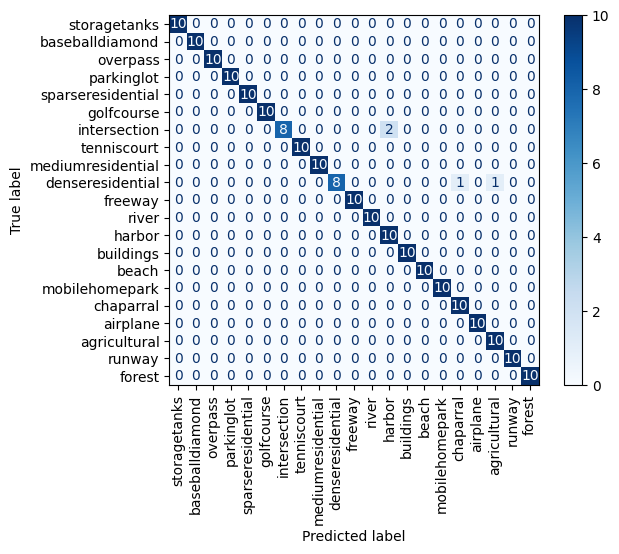

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    labels,
    pred,
    # display_labels=os.listdir("/content/UCMerced_LandUse/Images"),
    xticks_rotation="vertical",
    cmap=plt.cm.Blues,
)
plt.show()

## save model


In [ ]:
drive_path = "/content/drive/MyDrive/Colab Notebooks/cv-assignment-2/resnet50.pth"
local_path = "D:/MS/cv-assignment-2/model.pth"
torch.save(resnet, drive_path)

## fastai


In [ ]:
from fastai.vision.all import *

train_data = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(size=256, min_scale=1, max_lighting=0),
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
)
dl = train_data.dataloaders(path / "UCMerced_LandUse/Images", bs=64)

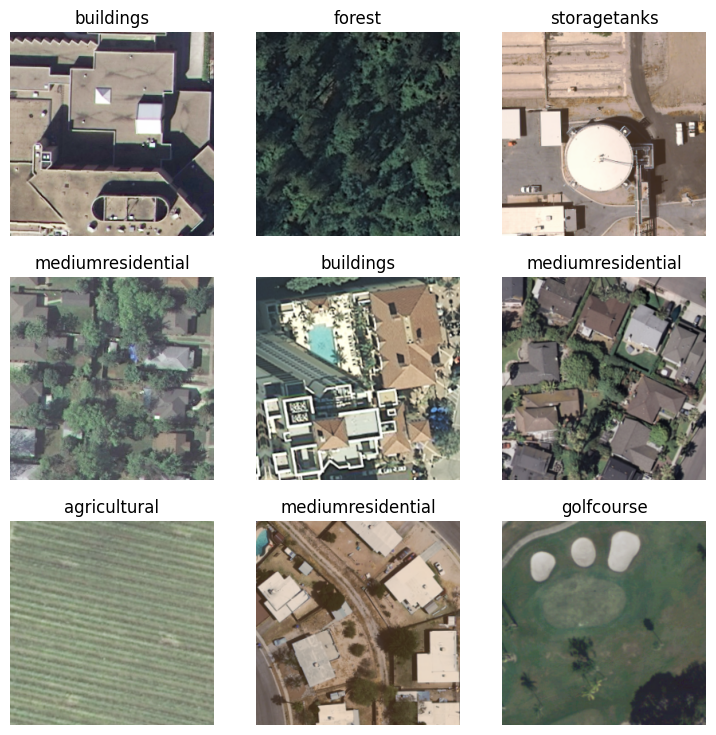

In [ ]:
dl.show_batch()

In [ ]:
l = vision_learner(dl, resnet50, metrics=accuracy)
l.fine_tune(14)
l.export("/content/drive/MyDrive/Colab Notebooks/cv-assignment-2/fastai-model.pkl")

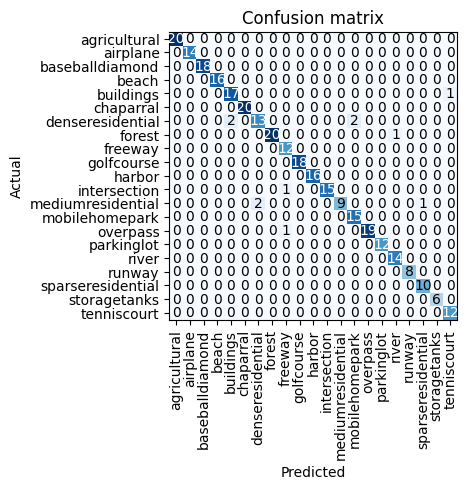

In [ ]:
interp = ClassificationInterpretation.from_learner(l)
interp.plot_confusion_matrix()

# BoVW


In [156]:
import numpy as np
import cv2 as cv
import skimage.io as io
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MiniBatchKMeans
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from ipywidgets import IntProgress
import pandas as pd
from sklearn.preprocessing import normalize

## 1. Feature Extraction


In [157]:
from torchvision.transforms import v2
from torchvision.transforms.functional import rotate
import random


class RandomRotationFromList:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return rotate(img, angle)


image_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Grayscale(),
        RandomRotationFromList([90, 180, 270]),
        v2.RandomVerticalFlip(),
        v2.RandomResizedCrop(size=224)
    ]
)
test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Grayscale(),
        v2.Resize((256,256))
    ]
)
categories = os.listdir(path / "UCMerced_LandUse/Images")

In [158]:
class terrainDataset(Dataset):
    def __init__(self, path: Path, transform=None, target_transform=None, test=False):
        self.data = []
        self.categories = os.listdir(path)
        for category in self.categories:
            images = [path / category / image for image in os.listdir(path / category)]
            if test:
                images = images[90:]
            else:
                images = images[:90]
            self.data.extend(list(zip(images, [category] * len(images))))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(str(self.data[idx][0]))
        label = self.data[idx][1]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return (img, label)

In [159]:
train_ds = terrainDataset(
    path / "UCMerced_LandUse/Images",
    transform=image_transforms
)
test_ds = terrainDataset(
    path / "UCMerced_LandUse/Images",
    transform = test_transforms,
    test=True,
)

train_dl = DataLoader(train_ds, 64, shuffle=True)
test_dl = DataLoader(test_ds, 32)

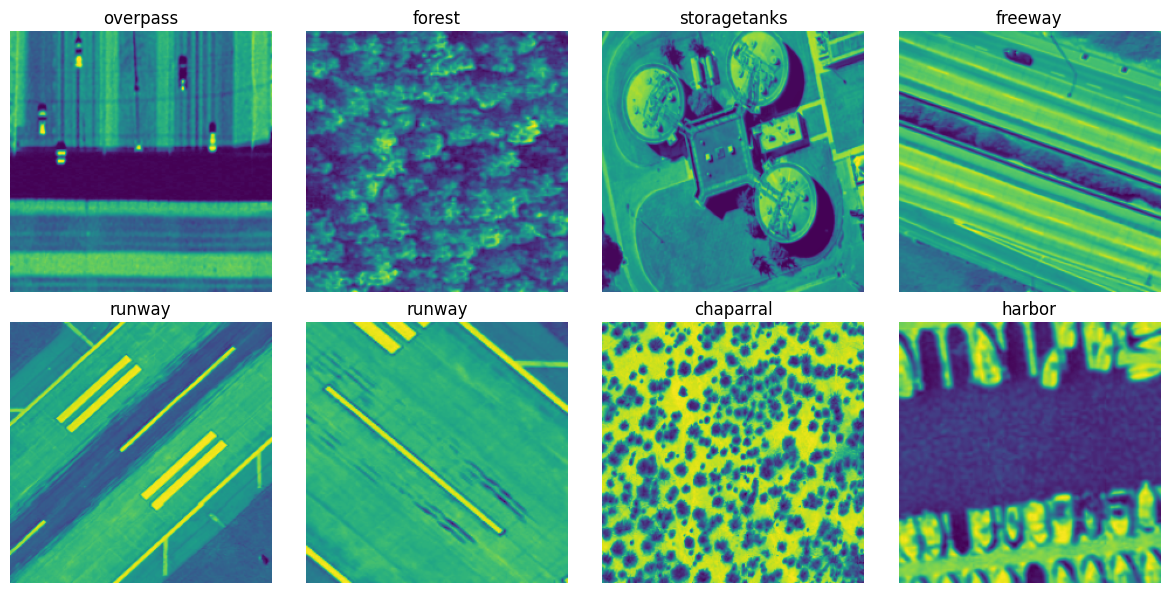

In [ ]:
showbatch(train_ds)

In [ ]:
def compute_descriptors_2(x, y, algorithm):
    descriptors, kps, labels = [], [], []
    for img, lbl in list(zip(x, y)):
        kp, d = algorithm.detectAndCompute(img.numpy()[0], None)
        if len(kp) == 0:
            print("none")
            continue
        descriptors.append(d)
        labels.append(lbl)
        kps.append(kp)
    return descriptors, kps, labels


def extraction_loop(dl, extractor):
    progress = IntProgress(min=0, max=100)
    display(progress)
    td, tkp, tl = [], [], []
    for b, (images, labels) in enumerate(dl):
        d, k, l = compute_descriptors_2(images, labels, extractor)
        td.extend(d)
        tkp.extend(k)
        tl.extend(l)
        progress.value = ((b + 1) / len(dl)) * 100
        progress.description = f"{((b+1)*100)/len(dl):>0.1f}%"

    return (td, tkp, tl)


sift = cv.SIFT_create()
ORB = cv.ORB_create()
train_descriptors, train_kp, train_labels = [], [], []
for e in range(2):
    print(f"epoch: {e+1}")
    d, k, l = extraction_loop(train_dl, sift)
    train_descriptors.extend(d)
    train_kp.extend(k)
    train_labels.extend(l)

epoch: 1


IntProgress(value=0)

none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
epoch: 2


IntProgress(value=0)

none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none


In [ ]:
test_descriptors, test_kp, test_labels = extraction_loop(test_dl, sift)

IntProgress(value=0)

none


### Normalization


In [ ]:
from sklearn.preprocessing import Normalizer

normalize = Normalizer("l2")
normalize.fit(np.vstack(train_descriptors))

train_descriptors_n = [normalize.transform(desc) for desc in train_descriptors]
test_descriptors_n = [normalize.transform(desc) for desc in test_descriptors]

### Visualizing Keypoints


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


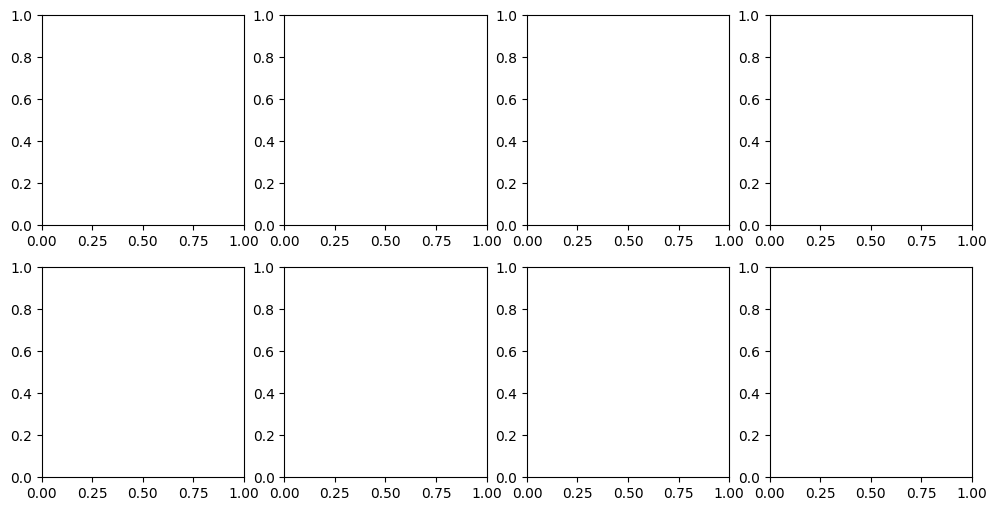

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(train_data) - 1, 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    index = idx[i]
    img = cv.imread(str(train_data[index][0]))
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.drawKeypoints(
        gray, train_kp[index], img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    label = train_ds.data[idx[i]][1]

    axes[i].imshow(img)
    axes[i].set_title(f"{label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Creating Vocabulary with KMeans clustering


In [ ]:
def create_vocabulary(features, n_start, n_end, step):

    inertia = []
    kmeans = []

    for i, n in enumerate(range(n_start, n_end, step)):
        kmeans.append(MiniBatchKMeans(n_clusters=n,batch_size=1000))
        kmeans[i].fit_predict(features)
        inertia.append(kmeans[i].inertia_)
        print("n_clusters: ", n, "inertia: ", kmeans[i].inertia_)
    return kmeans, inertia


# create visual words using KMeans clustering on training features
kmeans, inertia = create_vocabulary(np.vstack(train_descriptors_n), 1000, 1050, 100)
words = kmeans[0].cluster_centers_
c = kmeans[0].n_clusters
# words.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters:  1000 inertia:  119423.98527257728


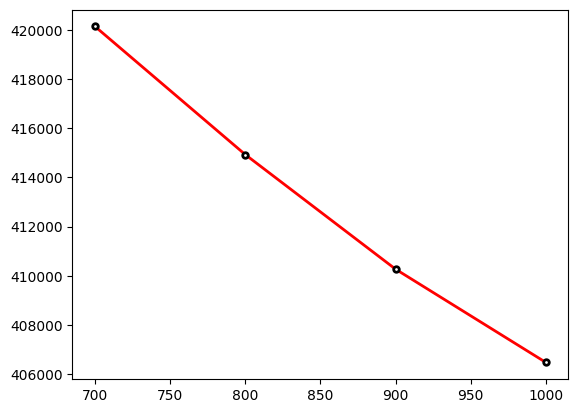

In [ ]:
plt.plot(
    range(700, 1050, 100),
    inertia,
    ".-",
    color="red",
    linewidth=2,
    markersize=8,
    markeredgewidth=2,
    markeredgecolor="black",
    markerfacecolor="white",
)

In [ ]:
w = [km.cluster_centers_ for km in kmeans]
c = [km.n_clusters for km in kmeans]
wc = dict(zip(c, w))
# np.save(path/'drive/MyDrive/Colab Notebooks/cv-assignment-2/wc.npy',wc)

In [ ]:
!pip install cloudpickle

# Load the wc dictionary using the correct encoding
wc = np.load(path/'drive/MyDrive/Colab Notebooks/cv-assignment-2/wc.npy', allow_pickle=True, encoding='latin1')
wc = wc.item()

In [ ]:
# np.save('words.npy',words)

words = np.load(drive_path / "words.npy")
words.shape

(200, 128)

## 3. Representing Images as Word-Count Vector


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric="cosine")
vocabulary_size = len(words)
y = range(vocabulary_size)
knn.fit(words, y)


def create_histograms(descriptors, clf=knn, word_count=vocabulary_size):
    X = []
    progress = IntProgress(min=0, max=100)
    display(progress)
    for i, d in enumerate(descriptors):
        pred_words = clf.predict(d)
        hist, _ = np.histogram(pred_words, range(word_count))
        X.append(hist)
        progress.value = ((i + 1) / len(descriptors)) * 100
        progress.description = f"{((i+1)*100)/len(descriptors):>0.1f}%"
    return X


train_X = create_histograms(train_descriptors_n)
test_X = create_histograms(test_descriptors_n)

IntProgress(value=0)

IntProgress(value=0)

In [ ]:
xs_train = []
xs_test = []
def create_histograms(descriptors, clf, word_count):
    X = []
    progress = IntProgress(min=0, max=100)
    display(progress)
    for i, d in enumerate(descriptors):
        pred_words = clf.predict(d)
        hist, _ = np.histogram(pred_words, range(word_count))
        X.append(hist)
        progress.value = ((i + 1) / len(descriptors)) * 100
        progress.description = f"{((i+1)*100)/len(descriptors):>0.1f}%"
    return X
# c = wc.keys()
# w = wc.values()
for c, w in list(zip(c,w)):
    if c<800:
        continue
    print(c)
    knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    y = range(c)
    knn.fit(w, y)
    xs_train.append(create_histograms(train_descriptors_n, knn, c))
    xs_test.append(create_histograms(test_descriptors_n, knn, c))

800


IntProgress(value=0)

IntProgress(value=0)

900


IntProgress(value=0)

IntProgress(value=0)

1000


IntProgress(value=0)

IntProgress(value=0)

In [ ]:
drive_path = Path("/content/drive/MyDrive/Colab Notebooks/cv-assignment-2")
xs_trn = zip(range(850, 1050, 50), xs_train)
xs_tst = zip(range(850, 1050, 50), xs_test)
np.save(drive_path / "k3_euc_train_x1050+.npy", xs_trn)
np.save(drive_path / "k3_euc_test_x1050+.npy", xs_tst)

In [ ]:
def tfidf(X):
    n = len(X)
    df = np.sum(np.array(X) > 0, axis=0)
    idf = np.log(n / df)
    tfidf = X * idf
    return tfidf


tfs_train = []
tfs_test = []

for train, test in list(zip(xs_train, xs_test)):
    tfs_train.append(tfidf(train))
    tfs_test.append(tfidf(test))

<ipython-input-100-41e92d4fb30b>:4: RuntimeWarning: divide by zero encountered in divide
  idf = np.log(n / df)
<ipython-input-100-41e92d4fb30b>:5: RuntimeWarning: invalid value encountered in multiply
  tfidf = X * idf


In [ ]:
# np.save("train_x.npy", train_X)
# np.save("test_x.npy", test_X)
train_X = np.load("train_x.npy")
test_X = np.load("test_x.npy")

## 3b. TF-IDF


In [ ]:
N_train = len(train_X)
N_test = len(test_X)

df = np.sum(np.array(train_X) > 0, axis=0)
idf = np.log(N_train / df)
tfidf = train_X * idf

df_test = np.sum(np.array(test_X) > 0, axis=0)
idf_test = np.log(N_test / df_test)
tfidf_test = test_X * idf_test

## 4. Training Classifiers


In [160]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def train_classifiers(x, y):

    # Random Forest Classifier
    rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    rnd_clf.fit(x, y)

    # SVM
    svm1 = Pipeline([("scaling", StandardScaler()), ("svm", LinearSVC())])
    svm1.fit(x, y)

    knnn = KNeighborsClassifier(1, metric="cosine")
    knnn.fit(x, y)
    return rnd_clf, svm1, knnn


def print_metrics(actual, predicted):
    print(
        f'Accuracy: {accuracy_score(actual,predicted[0]):>0.3f} | Presision: {precision_score(actual, predicted[0], average="macro"):>0.2f} | Recall: {recall_score(actual, predicted[0], average="macro"):>0.2f} | F1 Score: {f1_score(actual, predicted[0], average="macro"):>0.2f}'
    )
    print(
        f'Accuracy: {accuracy_score(actual,predicted[1]):>0.3f} | Presision: {precision_score(actual, predicted[1], average="macro"):>0.2f} | Recall: {recall_score(actual, predicted[1], average="macro"):>0.2f} | F1 Score: {f1_score(actual, predicted[1], average="macro"):>0.2f}'
    )
    print(
        f'Accuracy: {accuracy_score(actual,predicted[2]):>0.3f} | Presision: {precision_score(actual, predicted[2], average="macro"):>0.2f} | Recall: {recall_score(actual, predicted[2], average="macro"):>0.2f} | F1 Score: {f1_score(actual, predicted[2], average="macro"):>0.2f}'
    )

In [ ]:
random_forest, SVM, KNN = train_classifiers(tfidf, train_labels)
y1 = random_forest.predict(tfidf_test)
y2 = SVM.predict(tfidf_test)
y3 = KNN.predict(tfidf_test)
print_metrics(test_labels, [y1, y2, y3])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.191 | Presision: 0.10 | Recall: 0.19 | F1 Score: 0.11
Accuracy: 0.234 | Presision: 0.26 | Recall: 0.24 | F1 Score: 0.23
Accuracy: 0.273 | Presision: 0.29 | Recall: 0.27 | F1 Score: 0.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [165]:
_,train_labels = zip(*train_ds.data)
_,test_labels = zip(*test_ds.data)

In [183]:
idx = [len(d)>0 for d in train_X ]
train_X = [train_X[0]  for d in train_X]
len(train_X)

1890

In [166]:
random_forest, SVM, KNN = train_classifiers(train_X, train_labels)
y1 = random_forest.predict(test_X)
y2 = SVM.predict(test_X)
y3 = KNN.predict(test_X)
print_metrics(test_labels, [y1, y2, y3])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1890,) + inhomogeneous part.

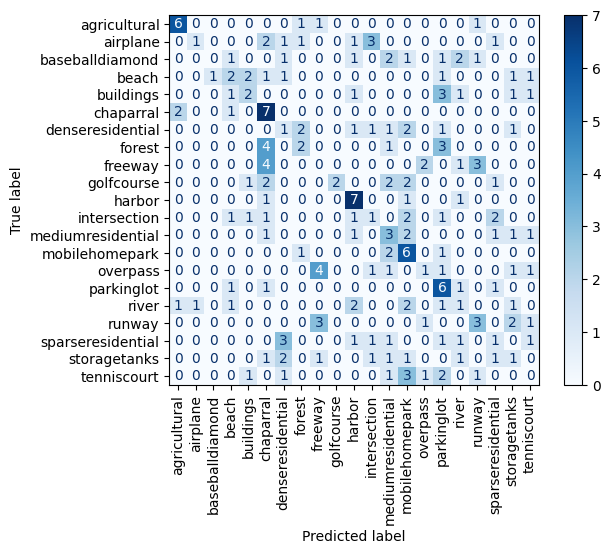

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    test_labels,
    y3,
    # display_labels=categories,
    xticks_rotation="vertical",
    cmap=plt.cm.Blues,
)
plt.show()

In [ ]:
xs_train[0]

array([ 1,  1,  0,  1,  0,  0,  1,  0,  0,  0,  1,  1,  1,  1,  0,  1,  0,
        0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  3,  0,  6,  1,  0,  0,  0,  1,  0,  0,  1,  3,  0,  0,  0,
        0,  1,  1,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  2,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        2,  2,  1,  1,  0,  0,  2,  1,  0,  0,  2,  0,  0,  1,  0,  6,  3,
        0,  1,  0,  3,  1,  2,  0,  1,  0,  0,  1,  0,  1,  0,  0,  3,  0,
        0,  2,  0,  1,  0,  1,  1,  2,  3,  0,  1,  0,  1,  0,  1,  2,  2,
        0,  1,  1,  0,  1, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  0,  2,  0,  1,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,
        0,  1,  0,  1,  1,  0,  0,  0,  0,  2,  3,  0,  1,  0,  1,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  2,  0,  1,  1,  2,  0,  2,  0,  1,  0,
        0,  0,  0,  1,  0

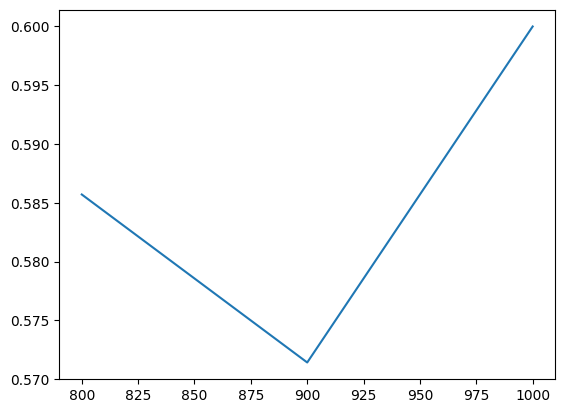

In [ ]:
from sklearn.metrics import accuracy_score

ps = []
accs = []
for x, x_test in list(zip(xs_train, xs_test)):
    knnn = KNeighborsClassifier(1, metric="euclidean")
    knnn.fit(x, train_labels)
    pred = knnn.predict(x_test)
    ps.append(pred)
    accs.append(accuracy_score(test_labels, pred))
plt.plot(range(800,1050,100), accs)

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.notebook import tqdm
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

In [130]:

def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        print("Path :" ,path)
        for file in tqdm(os.listdir(path)):
          #print("File Name: ",filename)
          img = cv2.imread(os.path.join(path,file) ,cv2.IMREAD_GRAYSCALE)
          if img is not None:
            img = cv2.resize(img, (120, 120))
            category.append(img)
        images[filename] = category
    return images

images = train_ds.data
test = test_ds.data

In [132]:
def orb_features(images):
    orb_vectors = {}
    descriptor_list = []
    orb = cv2.ORB_create()
    for key,value in images:
        features = []
        img = cv.imread(str(key),cv.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img,None)
        #if kp/descriptor are detected
        if des is not None:
            descriptor_list.extend(des)

        features.append(des)
        orb_vectors[key] = features
    return [descriptor_list, orb_vectors]

ORBs = orb_features(images)
# Takes the descriptor list which is unordered one
descriptor_list = ORBs[0]
# Takes the ORB features that is seperated class by class for train data
all_bovw_feature = ORBs[1]
# Takes the ORB features that is seperated class by class for test data

ORBs_test = orb_features(test)
test_descriptor_list = ORBs_test[0]
test_bovw_feature = ORBs_test[1] #directly accessed descriptor_list here using [1] index

In [135]:
def kmeans(k, descriptor_list):
    kmeans = MiniBatchKMeans(n_clusters = k)
    print("...")
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

# Takes the central points which is visual words
# It is suggest to make experiments with cluster centroid and observe its imapact on accuracies
visual_words = kmeans(30, descriptor_list)

...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [136]:
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i])
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [ ]:
def image_class(all_bovw, centers):
  dict_feature = {}
  for key,value in all_bovw.items():
      category = []
      for img in tqdm(value):
          histogram = np.zeros(len(centers))
          if img is None:
            continue
          for each_feature in img:
              ind = find_index(each_feature, centers)
              histogram[ind] += 1
          category.append(histogram)
      dict_feature[key] = category
  return dict_feature

# Creates histograms for train data
bovw_train = image_class(all_bovw_feature, visual_words)
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words)

In [153]:
train_X = list(bovw_train.values())
test_X = list(bovw_test.values())

In [138]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in tqdm(test_val):
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]

# Call the knn function
results_bowl = knn(bovw_train, bovw_test)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [141]:

def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(str(key) + " : %" + str(acc))

# Calculates the accuracies and write the results to the console.
accuracy(results_bowl)

Average accuracy: %0.0

Class based accuracies: 

/content/UCMerced_LandUse/Images/intersection/intersection88.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection31.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection58.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection49.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection23.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection60.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection48.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection59.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection74.tif : %0.0
/content/UCMerced_LandUse/Images/intersection/intersection99.tif : %0.0
/content/UCMerced_LandUse/Images/runway/runway97.tif : %0.0
/content/UCMerced_LandUse/Images/runway/runway36.tif : %0.0
/content/UCMerced_LandUse/Images/runway/runway31.tif : %0.0
/content/UCMerced_LandUse/Images/runway/runway84.t